In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob as gb

import torch
import torch.nn as nn
from torch import topk
from torchvision import transforms

In [2]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=6):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 2), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 2), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout2 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(2, 1), stride=(2, 1))
        self.bn3 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.dropout3 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(2048, 128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 6)


    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        # print('x:', x.shape)
        x = self.conv1(x)
        # print('conv1:', x.shape)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        # print('pool1:', x.shape)
        x = self.dropout1(x)
        x = self.conv2(x)
        # print('conv2:', x.shape)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        # print('pool2:', x.shape)
        x = self.dropout2(x)
        x = self.conv3(x)
        # print('conv3:',x.shape)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        # print('pool3:',x.shape)
        x = x.view(x.size(0), -1)
        # print('flatten:', x.shape)
        x = self.fc1(x)
        # print('fc1:', x.shape)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        # print('fc2:', x.shape)
        return x

In [3]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = EEGNet().to(device)
model = model.eval()
model.load_state_dict(torch.load("C:\\Users\\a1882\Desktop\EEG\\normal\model\cnn_conv3_128_100e_97.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [117]:
def grad_cam(model, image_tensor):
    # Set the model to evaluation mode
    model.eval()

    # Create a hook to extract the gradients from the last convolutional layer
    gradients = []
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    handle = model.conv3.register_backward_hook(backward_hook)

    # Create a hook to extract the activations from the last convolutional layer
    activations = []
    def forward_hook(module, input, output):
        activations.append(output)
    handle = model.conv3.register_forward_hook(forward_hook)

    # Forward pass
    output = model(image_tensor)

    # Backward pass
    output.backward(torch.ones_like(output))

    # Remove the hooks
    handle.remove()

    # Compute the Grad-CAM
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    activations = activations[0]
    for i in range(32):
        activations[:, i] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().detach(), 0)
    # heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)

    return heatmap.numpy()

In [269]:
df = pd.read_csv("C:\\Users\\a1882\\Desktop\\EEG\\normal\\data\\128_s100\\walkbase_zyy_epocflex_2023_window_8.csv", header=None)

In [270]:
data = df
data = data.values
data = torch.from_numpy(data)
data =data.unsqueeze(0)
image_tensor = data.float()
image_tensor.shape

torch.Size([1, 32, 128])

In [271]:
heatmap = grad_cam(model, image_tensor)

C:\Users\a1882\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


(16, 8)


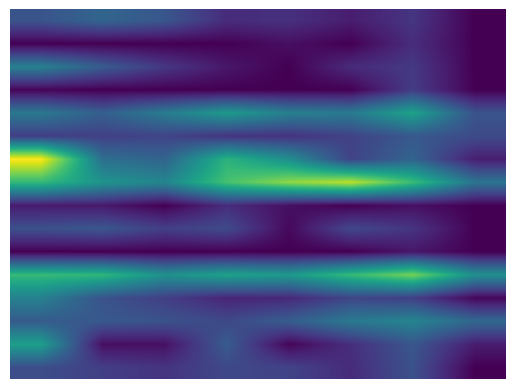

In [272]:
print(heatmap.shape)
heatmap_pd = pd.DataFrame(heatmap)
fig,ax = plt.subplots()
he = plt.imshow(heatmap_pd,interpolation = 'bilinear',aspect='auto')
# fig.colorbar(he, ax=ax)
plt.axis('off')
fig.patch.set_visible(False)
fig.savefig('CAM_heatmap.png')

In [273]:
data_p = df

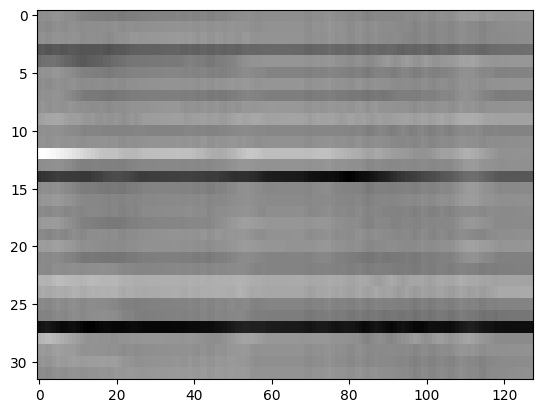

In [274]:
fig,ax = plt.subplots()
im = ax.imshow(data_p,cmap='gray', aspect='auto')
# im = ax.imshow(data_p, cmap='gray')
# plt.axis('off')
# fig.patch.set_visible(False)
fig.savefig('CAM_ch.png')
plt.show()

(480, 640, 4)
(480, 640, 4)


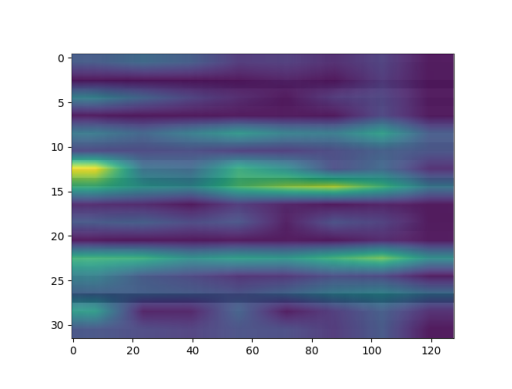

In [275]:
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import zoom

# Load the input image and convert it to a NumPy array
image = Image.open('CAM_ch.png')
image = np.array(image)
heatmap_ = Image.open('CAM_heatmap.png')
heatmap_ = np.array(heatmap_)
print(image.shape)
print(heatmap_.shape)
fig,ax = plt.subplots()
# Overlay the heatmap on the input image
plt.imshow(image,alpha=1)
plt.imshow(heatmap_, alpha=0.8)
plt.axis('off')
plt.show()
fig.savefig('CAM_wb_6.png',dpi = 330)

In [267]:
# import cv2
# import numpy as np
#
# def upsample_heatmap(heatmap, output_size):
#     input_height, input_width = heatmap.shape[:2]
#     output_height, output_width = output_size
#
#     # 计算缩放比例
#     scale_x = output_width / input_width
#     scale_y = output_height / input_height
#
#     # 创建输出图像
#     output_image = np.zeros((output_height, output_width))
#
#     # 遍历输出图像的每个像素
#     for y in range(output_height):
#         for x in range(output_width):
#             # 计算对应于输入热力图的位置
#             input_x = x / scale_x
#             input_y = y / scale_y
#
#             # 使用最近邻插值获取输入热力图中的值
#             value = heatmap[int(input_y), int(input_x)]
#
#             # 将值赋给输出图像的对应位置
#             output_image[y, x] = value
#
#     return output_image
#
# # 读取输入热力图
# heatmap = cv2.imread('CAM_heatmap.png', cv2.IMREAD_GRAYSCALE)
#
# # 设置输出图像的大小
# output_size = (480, 640)
#
# # 上采样热力图
# upsampled_heatmap = upsample_heatmap(heatmap, output_size)
#
# # 显示输出图像
# cv2.imshow('Upsampled Heatmap', upsampled_heatmap)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [268]:
# img = cv2.imread('CAM_ch.png')
# CAM = cv2.imread('CAM_heatmap.png')
# height, width, _ = img.shape
# heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
# result = heatmap * 0.3 + img * 0.5
# cv2.imwrite('CAM1.png', result)